# Predicción de la Recuperación de Oro 

Este proyecto tiene como objetivo desarrollar un prototipo de modelo de machine learning para Zyfra, una empresa que ofrece soluciones de eficiencia para la industria pesada. El modelo buscará predecir la cantidad de oro extraído del mineral, lo que permitirá optimizar la producción y eliminar parámetros no rentables.

El proceso de extracción de oro del mineral implica varias etapas, incluyendo la flotación y dos etapas de purificación. Contamos con datos de extracción y purificación de tres archivos: gold_recovery_train.csv, gold_recovery_test.csv, y gold_recovery_full.csv. Estos datasets contienen información sobre el proceso tecnológico, los parámetros de las etapas y las concentraciones de metales (Au, Ag, Pb).

## Carga de datos 

In [1]:
import pandas as pd

df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

print("Primeras filas del DataFrame de entrenamiento:")
print(df_train.head())
print("\nInformación general del DataFrame de entrenamiento:")
df_train.info()

print("\nPrimeras filas del DataFrame de prueba:")
print(df_test.head())
print("\nInformación general del DataFrame de prueba:")
df_test.info()

print("\nPrimeras filas del DataFrame completo:")
print(df_full.head())
print("\nInformación general del DataFrame completo:")
df_full.info()

Primeras filas del DataFrame de entrenamiento:
                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   


## Preparación de datos

Verificar la fórmula de recuperación.

In [2]:
# Calcular la recuperación para el proceso rougher en el dataset de entrenamiento
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

# Evitar la división por cero en el cálculo de la recuperación
calculated_recovery = (C * (F - T)) / (F * (C - T)) * 100
calculated_recovery[F * (C - T) == 0] = pd.NA 

# Eliminar valores NaN en la columna de recuperación real y calculada para una comparación justa
df_train_cleaned = df_train.dropna(subset=['rougher.output.recovery'])
calculated_recovery = calculated_recovery.dropna()

# Alinear los índices
aligned_recovery = pd.concat([df_train_cleaned['rougher.output.recovery'], calculated_recovery], axis=1).dropna()

# Calcular el Error Absoluto Medio (MAE) entre la recuperación real y la calculada
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(aligned_recovery['rougher.output.recovery'], aligned_recovery[0])

print(f"El Error Absoluto Medio (MAE) entre la recuperación real y la calculada es: {mae}")


El Error Absoluto Medio (MAE) entre la recuperación real y la calculada es: 9.303415616264301e-15


#### Identifica las características ausentes en el conjunto de prueba.

In [3]:
# Identificar las columnas en el dataset de entrenamiento
train_cols = df_train.columns

# Identificar las columnas en el dataset de prueba
test_cols = df_test.columns

# Encontrar las columnas que están en el conjunto de entrenamiento pero no en el conjunto de prueba
missing_cols_in_test = train_cols.difference(test_cols)

print("Características presentes en el conjunto de entrenamiento pero ausentes en el conjunto de prueba:")
print(missing_cols_in_test)

Características presentes en el conjunto de entrenamiento pero ausentes en el conjunto de prueba:
Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concent

#### Categorización de características ausentes:

In [4]:

# Categorizar las características ausentes por tipo
missing_features_categorized = {
    'input': [],
    'output': [],
    'state': [],
    'calculation': []
}

for col in missing_cols_in_test:
    if 'input' in col:
        missing_features_categorized['input'].append(col)
    elif 'output' in col:
        missing_features_categorized['output'].append(col)
    elif 'state' in col:
        missing_features_categorized['state'].append(col)
    elif 'calculation' in col:
        missing_features_categorized['calculation'].append(col)

print("Características ausentes categorizadas por tipo:")
for param_type, features in missing_features_categorized.items():
    print(f"\nTipo: {param_type} ({len(features)} características)")
    for feature in features:
        print(f"- {feature}")


Características ausentes categorizadas por tipo:

Tipo: input (0 características)

Tipo: output (30 características)
- final.output.concentrate_ag
- final.output.concentrate_au
- final.output.concentrate_pb
- final.output.concentrate_sol
- final.output.recovery
- final.output.tail_ag
- final.output.tail_au
- final.output.tail_pb
- final.output.tail_sol
- primary_cleaner.output.concentrate_ag
- primary_cleaner.output.concentrate_au
- primary_cleaner.output.concentrate_pb
- primary_cleaner.output.concentrate_sol
- primary_cleaner.output.tail_ag
- primary_cleaner.output.tail_au
- primary_cleaner.output.tail_pb
- primary_cleaner.output.tail_sol
- rougher.output.concentrate_ag
- rougher.output.concentrate_au
- rougher.output.concentrate_pb
- rougher.output.concentrate_sol
- rougher.output.recovery
- rougher.output.tail_ag
- rougher.output.tail_au
- rougher.output.tail_pb
- rougher.output.tail_sol
- secondary_cleaner.output.tail_ag
- secondary_cleaner.output.tail_au
- secondary_cleaner.outpu

#### Preprocesamiento de datos

In [5]:
# Convertir la columna 'date' a tipo datetime
if 'date' not in df_train.columns and df_train.index.name == 'date':
    df_train.reset_index(inplace=True)
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.set_index('date')

if 'date' not in df_test.columns and df_test.index.name == 'date':
    df_test.reset_index(inplace=True)
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.set_index('date')

if 'date' not in df_full.columns and df_full.index.name == 'date':
    df_full.reset_index(inplace=True)
df_full['date'] = pd.to_datetime(df_full['date'])
df_full = df_full.set_index('date')

# Manejar valores faltantes en los datasets indexados
df_train_filled = df_train.fillna(method='ffill')
df_test_filled = df_test.fillna(method='ffill')
df_full_filled = df_full.fillna(method='ffill') 

# Seleccionar las columnas objetivo del dataset completo basándose en el índice de fecha del dataset de prueba
target_test_rougher = df_full_filled.loc[df_test_filled.index, 'rougher.output.recovery']
target_test_final = df_full_filled.loc[df_test_filled.index, 'final.output.recovery']

features_test_cols = df_test_filled.columns

# Seleccionar solo las columnas de características presentes en el conjunto de prueba para el conjunto de entrenamiento
features_train = df_train_filled[features_test_cols]
target_train_rougher = df_train_filled['rougher.output.recovery']
target_train_final = df_train_filled['final.output.recovery']
features_test = df_test_filled 

# Eliminar filas con values NaN restantes 
features_train = features_train.dropna()
target_train_rougher = target_train_rougher.loc[features_train.index]
target_train_final = target_train_final.loc[features_train.index]

features_test = features_test.dropna()
target_test_rougher = target_test_rougher.loc[features_test.index]
target_test_final = target_test_final.loc[features_test.index]


print("Dimensiones de los datos después del preprocesamiento:")
print("Conjunto de entrenamiento - Características:", features_train.shape)
print("Conjunto de entrenamiento - Objetivo Rougher:", target_train_rougher.shape)
print("Conjunto de entrenamiento - Objetivo Final:", target_train_final.shape)
print("\nConjunto de prueba - Características:", features_test.shape)
print("Conjunto de prueba - Objetivo Rougher:", target_test_rougher.shape)
print("Conjunto de prueba - Objetivo Final:", target_test_final.shape)

Dimensiones de los datos después del preprocesamiento:
Conjunto de entrenamiento - Características: (16860, 52)
Conjunto de entrenamiento - Objetivo Rougher: (16860,)
Conjunto de entrenamiento - Objetivo Final: (16860,)

Conjunto de prueba - Características: (5856, 52)
Conjunto de prueba - Objetivo Rougher: (5856,)
Conjunto de prueba - Objetivo Final: (5856,)


#### Análisis de concentración de metales (DataFrame)

In [6]:
# Seleccionar las columnas relevantes para cada metal en las etapas rougher, primary_cleaner y final
metals = ['au', 'ag', 'pb']
stages = ['rougher.output', 'primary_cleaner.output', 'final.output']

metal_concentration_avg = {}

for metal in metals:
    metal_concentration_avg[metal] = {}
    for stage in stages:
        column_name = f'{stage}.concentrate_{metal}'
        # Verificar si la columna existe antes de calcular la media
        if column_name in df_full_filled.columns:
            metal_concentration_avg[metal][stage] = df_full_filled[column_name].mean()
        else:
            metal_concentration_avg[metal][stage] = None 

# Convertir el diccionario a un DataFrame para una mejor visualización
metal_concentration_df = pd.DataFrame(metal_concentration_avg)

print("Concentración promedio de metales en diferentes etapas:")
metal_concentration_df

Concentración promedio de metales en diferentes etapas:


,au,ag,pb
rougher.output,17.831509,10.845609,6.886869
primary_cleaner.output,29.119967,7.666972,8.809217
final.output,39.891718,4.768013,9.071366


#### Visualización de concentración de metales (Gráfico de barras)

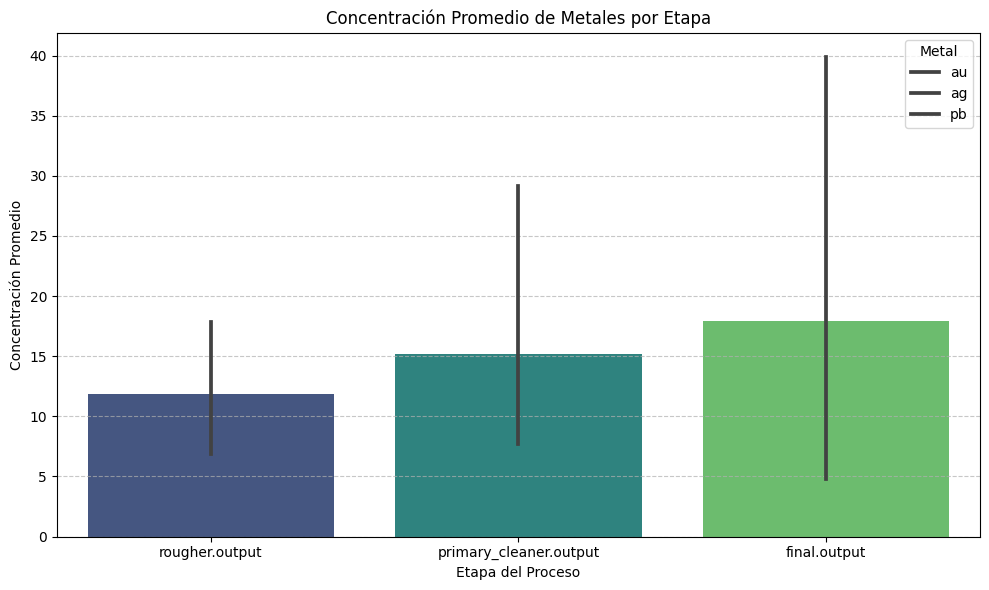

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=metal_concentration_df.T, palette='viridis')
plt.title('Concentración Promedio de Metales por Etapa')
plt.xlabel('Etapa del Proceso')
plt.ylabel('Concentración Promedio')
plt.xticks(rotation=0)
plt.legend(title='Metal', labels=metal_concentration_df.columns)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Comparación de distribuciones de tamaño de partículas (Histograma)

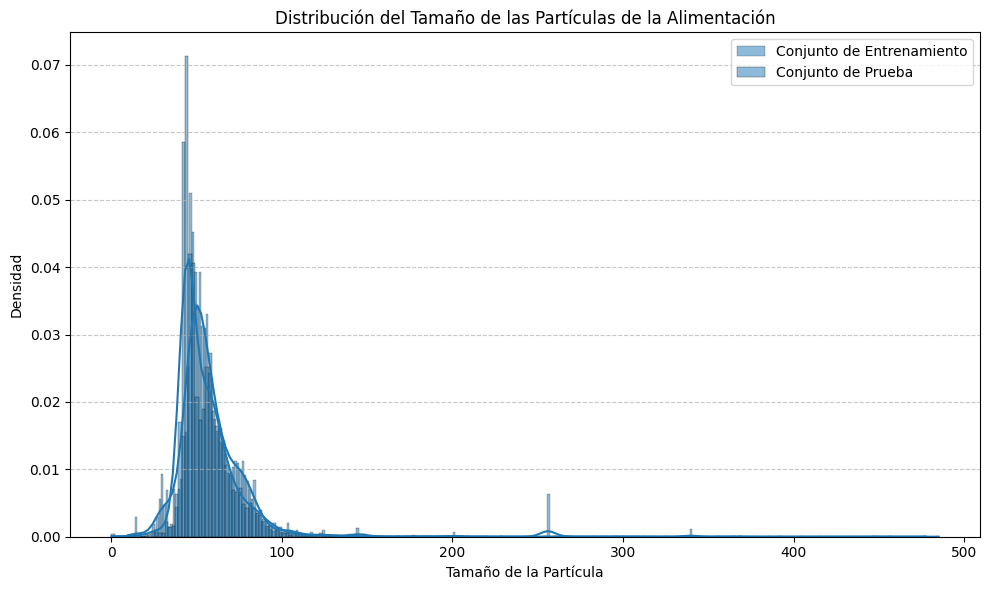

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar la columna 
feed_size_train = df_train_filled['rougher.input.feed_size'].dropna()
feed_size_test = df_test_filled['rougher.input.feed_size'].dropna()

# Crear el histograma
plt.figure(figsize=(10, 6))
sns.histplot(feed_size_train, label='Conjunto de Entrenamiento', kde=True, stat='density', common_norm=False)
sns.histplot(feed_size_test, label='Conjunto de Prueba', kde=True, stat='density', common_norm=False)

plt.title('Distribución del Tamaño de las Partículas de la Alimentación')
plt.xlabel('Tamaño de la Partícula')
plt.ylabel('Densidad')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Análisis de concentraciones totales (Cálculo)

In [9]:
# Calcular la concentración total de todas las sustancias (Au, Ag, Pb, Sol) en diferentes etapas

# Etapas a analizar
stages_to_analyze = ['rougher.input', 'rougher.output', 'primary_cleaner.output', 'final.output']
substances = ['au', 'ag', 'pb', 'sol']

# DataFrame para almacenar las concentraciones totales
total_concentration = pd.DataFrame(index=df_full_filled.index)

for stage in stages_to_analyze:
    if stage == 'rougher.input':
        # Para rougher.input, las columnas son rougher.input.feed_au, etc.
        stage_columns = [f'{stage}.feed_{substance}' for substance in substances if f'{stage}.feed_{substance}' in df_full_filled.columns]
    else:
        # Para las otras etapas, las columnas son stage.concentrate_substance
        stage_columns = [f'{stage}.concentrate_{substance}' for substance in substances if f'{stage}.concentrate_{substance}' in df_full_filled.columns]
    
    if stage_columns:
        total_concentration[stage] = df_full_filled[stage_columns].sum(axis=1)
    else:
        total_concentration[stage] = pd.NA
        
print("Primeras 5 filas del DataFrame con concentraciones totales:")
print(total_concentration.head())

print("\nEstadísticas descriptivas de las concentraciones totales por etapa:")
print(total_concentration.describe())

Primeras 5 filas del DataFrame con concentraciones totales:
                     rougher.input  rougher.output  primary_cleaner.output  \
date                                                                         
2016-01-15 00:00:00      51.680034       66.424950               72.640924   
2016-01-15 01:00:00      50.659114       67.012710               72.543485   
2016-01-15 02:00:00      50.609929       66.103793               72.095042   
2016-01-15 03:00:00      51.061546       65.752751               59.957723   
2016-01-15 04:00:00      47.859163       65.908382               71.321010   

                     final.output  
date                               
2016-01-15 00:00:00     63.644396  
2016-01-15 01:00:00     63.957723  
2016-01-15 02:00:00     64.311180  
2016-01-15 03:00:00     63.573449  
2016-01-15 04:00:00     64.004667  

Estadísticas descriptivas de las concentraciones totales por etapa:
       rougher.input  rougher.output  primary_cleaner.output  final.outp

#### Análisis de concentraciones totales (Visualización - Box plot)

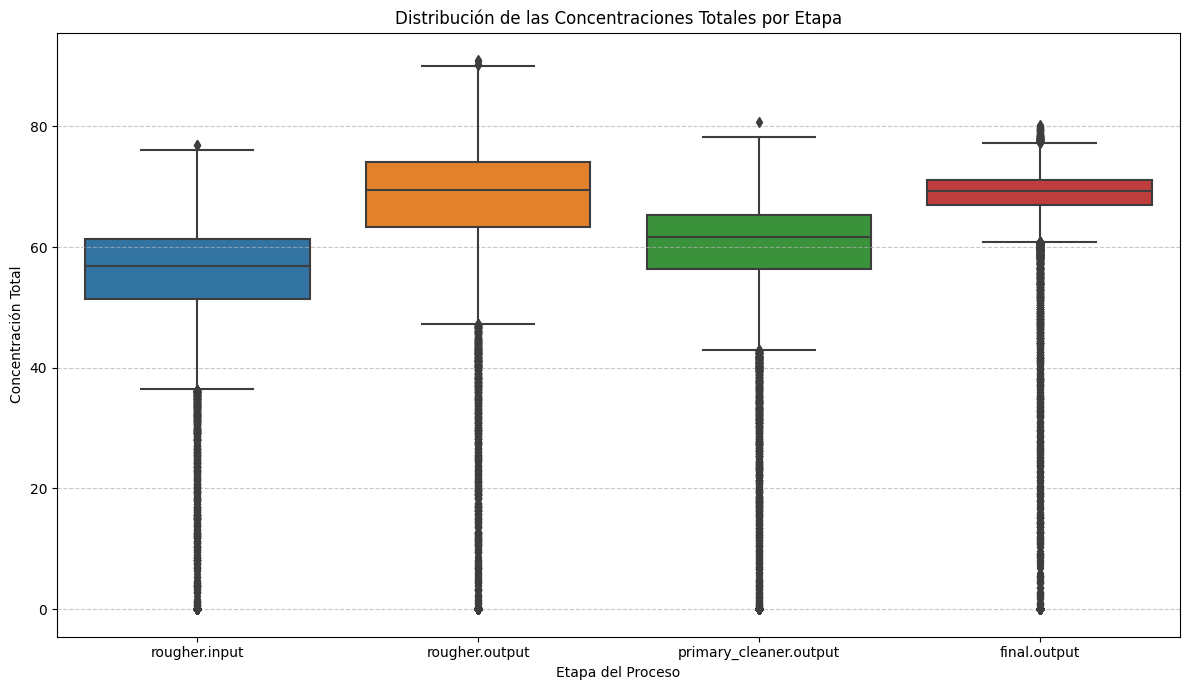

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear box plots para las concentraciones totales en cada etapa
plt.figure(figsize=(12, 7))
sns.boxplot(data=total_concentration)

plt.title('Distribución de las Concentraciones Totales por Etapa')
plt.xlabel('Etapa del Proceso')
plt.ylabel('Concentración Total')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Eliminación de anomalías de concentración total

In [11]:
# Usaremos un umbral pequeño para considerar valores cercanos a cero
zero_concentration_threshold = 1e-6
anomalous_indices = total_concentration[(total_concentration < zero_concentration_threshold).any(axis=1)].index

df_full_cleaned = df_full_filled.drop(anomalous_indices)

# Ahora, actualizar los conjuntos de entrenamiento y prueba 
df_train_cleaned_anomalies = df_train_filled.loc[df_full_cleaned.index.intersection(df_train_filled.index)]
df_test_cleaned_anomalies = df_test_filled.loc[df_full_cleaned.index.intersection(df_test_filled.index)]

# Actualizar las características y objetivos de entrenamiento y prueba
features_train_cleaned = df_train_cleaned_anomalies[features_test_cols]
target_train_rougher_cleaned = df_train_cleaned_anomalies['rougher.output.recovery']
target_train_final_cleaned = df_train_cleaned_anomalies['final.output.recovery']

features_test_cleaned = df_test_cleaned_anomalies[features_test_cols]  
target_test_rougher_cleaned = df_full_cleaned.loc[features_test_cleaned.index, 'rougher.output.recovery'] 
target_test_final_cleaned = df_full_cleaned.loc[features_test_cleaned.index, 'final.output.recovery'] 

print("Dimensiones de los datos después de eliminar anomalías:")
print("Conjunto de entrenamiento - Características:", features_train_cleaned.shape)
print("Conjunto de entrenamiento - Objetivo Rougher:", target_train_rougher_cleaned.shape)
print("Conjunto de entrenamiento - Objetivo Final:", target_train_final_cleaned.shape)
print("\nConjunto de prueba - Características:", features_test_cleaned.shape)
print("Conjunto de prueba - Objetivo Rougher:", target_test_rougher_cleaned.shape)
print("Conjunto de prueba - Objetivo Final:", target_test_final_cleaned.shape)

Dimensiones de los datos después de eliminar anomalías:
Conjunto de entrenamiento - Características: (15026, 52)
Conjunto de entrenamiento - Objetivo Rougher: (15026,)
Conjunto de entrenamiento - Objetivo Final: (15026,)

Conjunto de prueba - Características: (5258, 52)
Conjunto de prueba - Objetivo Rougher: (5258,)
Conjunto de prueba - Objetivo Final: (5258,)


#### Descripción de análisis y eliminación de anomalías de concentración total

Al analizar las distribuciones de las concentraciones totales de todas las sustancias (Au, Ag, Pb, Sol) en las diferentes etapas del proceso mediante diagramas de caja, observamos la presencia de valores atípicos, particularmente en concentraciones cercanas a cero. Estos valores son físicamente irrealistas en un proceso de extracción de metales y probablemente representan errores en la medición o el registro de datos.

Dado que estos valores anómalos pueden distorsionar el entrenamiento del modelo y llevar a predicciones incorrectas, decidimos eliminar las filas donde la concentración total en cualquiera de las etapas analizadas (rougher.input, rougher.output, primary_cleaner.output, final.output) es extremadamente baja (cercana a cero, utilizando un umbral de 1e-6).

La eliminación de estas anomalías resultó en una reducción en el número de filas en los conjuntos de entrenamiento y prueba, como se muestra en las dimensiones de los datos después del preprocesamiento. Esto nos deja con conjuntos de datos más limpios y representativos para el entrenamiento y evaluación del modelo, lo que debería mejorar su rendimiento y fiabilidad.

#### Construcción del Modelo
Implementación de la función sMAPE

In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Función para calcular el sMAPE individual
def smape(y_true, y_pred):
    # Evitar la división por cero: si la suma de los valores absolutos es cero, sMAPE es 0
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Usar np.where para manejar la división por cero de forma segura
    # Si el denominador es cero, el error absoluto es cero, por lo que el sMAPE para ese punto es 0.
    smape_values = np.where(denominator == 0, 0, np.abs(y_true - y_pred) / denominator)
    return np.mean(smape_values) * 100

# Función para calcular el sMAPE final ponderado
def final_smape(smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

print("Función smape y final_smape implementadas.")

Función smape y final_smape implementadas.


#### Definición de modelos y preparación

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

# Definir los modelos a evaluar
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=12345)
}

# Definir los conjuntos de características y objetivos para rougher y final
X_train = features_train_cleaned
y_train_rougher = target_train_rougher_cleaned
y_train_final = target_train_final_cleaned

# Usaremos KFold para dividir los datos en pliegues
kf = KFold(n_splits=5, shuffle=True, random_state=12345)

print("Modelos definidos y datos preparados para validación cruzada.")

Modelos definidos y datos preparados para validación cruzada.


#### Validación cruzada de modelos

In [14]:
from sklearn.model_selection import cross_val_score

# Crear un scorer personalizado para sMAPE
smape_scorer = make_scorer(smape, greater_is_better=False) 

results = {}

for name, model in models.items():
    print(f"Evaluando modelo: {name}")

    # Realizar validación cruzada para la recuperación rougher
    cv_scores_rougher = cross_val_score(model, X_train, y_train_rougher, cv=kf, scoring=smape_scorer)
    avg_smape_rougher = -cv_scores_rougher.mean() 

    # Realizar validación cruzada para la recuperación final
    cv_scores_final = cross_val_score(model, X_train, y_train_final, cv=kf, scoring=smape_scorer)
    avg_smape_final = -cv_scores_final.mean() 

    # Calcular el sMAPE final ponderado promedio
    avg_final_weighted_smape = final_smape(avg_smape_rougher, avg_smape_final)

    results[name] = {
        "Avg sMAPE Rougher": avg_smape_rougher,
        "Avg sMAPE Final": avg_smape_final,
        "Avg Final Weighted sMAPE": avg_final_weighted_smape
    }

    print(f"  Avg sMAPE Rougher: {avg_smape_rougher:.4f}")
    print(f"  Avg sMAPE Final: {avg_smape_final:.4f}")
    print(f"  Avg Final Weighted sMAPE: {avg_final_weighted_smape:.4f}")
    print("-" * 30)

print("\nResultados de la validación cruzada:")
for name, metrics in results.items():
    print(f"Modelo: {name}")
    print(f"  sMAPE Rougher promedio: {metrics['Avg sMAPE Rougher']:.4f}")
    print(f"  sMAPE Final promedio: {metrics['Avg sMAPE Final']:.4f}")
    print(f"  sMAPE Final Ponderado promedio: {metrics['Avg Final Weighted sMAPE']:.4f}")
    print("-" * 30)

# Identificar el mejor modelo basado en el sMAPE final ponderado promedio
best_model_name = min(results, key=lambda k: results[k]['Avg Final Weighted sMAPE'])
best_model_smape = results[best_model_name]['Avg Final Weighted sMAPE']

print(f"\nEl mejor modelo basado en el sMAPE Final Ponderado promedio es: {best_model_name} con un sMAPE de {best_model_smape:.4f}")

Evaluando modelo: Linear Regression
  Avg sMAPE Rougher: 5.8557
  Avg sMAPE Final: 9.6702
  Avg Final Weighted sMAPE: 8.7166
------------------------------
Evaluando modelo: Random Forest Regressor
  Avg sMAPE Rougher: 3.5583
  Avg sMAPE Final: 6.2329
  Avg Final Weighted sMAPE: 5.5642
------------------------------

Resultados de la validación cruzada:
Modelo: Linear Regression
  sMAPE Rougher promedio: 5.8557
  sMAPE Final promedio: 9.6702
  sMAPE Final Ponderado promedio: 8.7166
------------------------------
Modelo: Random Forest Regressor
  sMAPE Rougher promedio: 3.5583
  sMAPE Final promedio: 6.2329
  sMAPE Final Ponderado promedio: 5.5642
------------------------------

El mejor modelo basado en el sMAPE Final Ponderado promedio es: Random Forest Regressor con un sMAPE de 5.5642


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import numpy as np

print("=== IMPLEMENTACIÓN DE ESCALADO DE DATOS ===\n")

# 1. Identificar columnas numéricas para escalar
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(f"Columnas numéricas a escalar: {len(numerical_cols)} columnas")

# 2. Crear diferentes escaladores
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler()
}

# 3. Evaluar modelos con diferentes escaladores
results_scaled = {}

for scaler_name, scaler in scalers.items():
    print(f"\n--- Evaluando con {scaler_name} ---")

    # Crear pipeline con escalado
    pipeline_lr = Pipeline([
        ('scaler', scaler),
        ('model', LinearRegression())
    ])

    pipeline_rf = Pipeline([
        ('scaler', scaler),
        ('model', RandomForestRegressor(random_state=12345))
    ])

    models_scaled = {
        f"Linear Regression + {scaler_name}": pipeline_lr,
        f"Random Forest + {scaler_name}": pipeline_rf
    }

    # Evaluar cada modelo escalado
    for name, model in models_scaled.items():
        # Validación cruzada para rougher
        cv_scores_rougher = cross_val_score(model, X_train, y_train_rougher, cv=kf, scoring=smape_scorer)
        avg_smape_rougher = -cv_scores_rougher.mean()

        # Validación cruzada para final
        cv_scores_final = cross_val_score(model, X_train, y_train_final, cv=kf, scoring=smape_scorer)
        avg_smape_final = -cv_scores_final.mean()

        # sMAPE final ponderado
        avg_final_weighted_smape = final_smape(avg_smape_rougher, avg_smape_final)

        results_scaled[name] = {
            "Avg sMAPE Rougher": avg_smape_rougher,
            "Avg sMAPE Final": avg_smape_final,
            "Avg Final Weighted sMAPE": avg_final_weighted_smape
        }

        print(f"  {name}:")
        print(f"    sMAPE Rougher: {avg_smape_rougher:.4f}")
        print(f"    sMAPE Final: {avg_smape_final:.4f}")
        print(f"    sMAPE Final Ponderado: {avg_final_weighted_smape:.4f}")


In [16]:

# Comparar todos los resultados (con y sin escalado)
print("=== COMPARACIÓN FINAL DE TODOS LOS MODELOS ===\n")

# Combinar resultados originales y escalados
all_results = {**results, **results_scaled}

# Crear DataFrame para mejor visualización
results_df = pd.DataFrame(all_results).T
results_df = results_df.sort_values('Avg Final Weighted sMAPE')

print("Ranking de modelos por sMAPE Final Ponderado:")
print(results_df)

# Identificar el mejor modelo global
best_overall_model = results_df.index[0]
best_overall_smape = results_df.iloc[0]['Avg Final Weighted sMAPE']

print(f"\n MEJOR MODELO GLOBAL: {best_overall_model}")
print(f"sMAPE Final Ponderado: {best_overall_smape:.4f}")


=== COMPARACIÓN FINAL DE TODOS LOS MODELOS ===

Ranking de modelos por sMAPE Final Ponderado:
                                    Avg sMAPE Rougher  Avg sMAPE Final  \
Random Forest Regressor                      3.558313         6.232859   
Random Forest + StandardScaler               3.557645         6.237994   
Random Forest + MinMaxScaler                 3.547537         6.245967   
Linear Regression + StandardScaler           5.855714         9.670206   
Linear Regression + MinMaxScaler             5.855714         9.670206   
Linear Regression                            5.855714         9.670206   

                                    Avg Final Weighted sMAPE  
Random Forest Regressor                             5.564222  
Random Forest + StandardScaler                      5.567906  
Random Forest + MinMaxScaler                        5.571359  
Linear Regression + StandardScaler                  8.716583  
Linear Regression + MinMaxScaler                    8.716583  
Linear Re

#### Selección del mejor modelo y evaluación en test

In [17]:
# Seleccionar el mejor modelo global basado en los resultados de la validación cruzada

# Extraer el nombre del modelo y el escalador si están en el nombre del mejor modelo
if ' + ' in best_overall_model:
    model_name, scaler_name = best_overall_model.split(' + ')
    best_model_estimator = models[model_name]
    # Obtener la instancia del escalador usado en el pipeline ganador
    best_scaler = scalers[scaler_name]
else:
    best_model_estimator = models[best_overall_model]
    best_scaler = None 

# Si se usó un escalador en el mejor modelo, incluirlo en los pipelines finales
if best_scaler:
    pipeline_rougher = Pipeline([
        ('scaler', best_scaler),
        ('model', best_model_estimator)
    ])

    pipeline_final = Pipeline([
        ('scaler', best_scaler),
        ('model', best_model_estimator)
    ])
else:
    # Si el mejor modelo no usó escalado, entrenar directamente el modelo
    pipeline_rougher = best_model_estimator
    pipeline_final = best_model_estimator


print(f"Entrenando el mejor pipeline ({best_overall_model}) para rougher recovery...")
# Usar los datos escalados si el mejor modelo incluye escalado, de lo contrario usar los datos limpios originales
if best_scaler:
    pipeline_rougher.fit(features_train_scaled, target_train_rougher_cleaned)
else:
    pipeline_rougher.fit(features_train_cleaned, target_train_rougher_cleaned)

print(f"Entrenando el mejor pipeline ({best_overall_model}) para final recovery...")
# Usar los datos escalados si el mejor modelo incluye escalado, de lo contrario usar los datos limpios originales
if best_scaler:
     pipeline_final.fit(features_train_scaled, target_train_final_cleaned)
else:
    pipeline_final.fit(features_train_cleaned, target_train_final_cleaned)

print("Realizando predicciones en el conjunto de prueba...")
# Usar los datos de prueba escalados si el mejor modelo incluye escalado, de lo contrario usar los datos de prueba limpios originales
if best_scaler:
    predictions_test_rougher = pipeline_rougher.predict(features_test_scaled)
    predictions_test_final = pipeline_final.predict(features_test_scaled)
else:
    predictions_test_rougher = pipeline_rougher.predict(features_test_cleaned)
    predictions_test_final = pipeline_final.predict(features_test_cleaned)

# Asegurarse de que las predicciones no contengan valores negativos, ya que la recuperación no puede ser negativa
predictions_test_rougher[predictions_test_rougher < 0] = 0
predictions_test_final[predictions_test_final < 0] = 0

# Calcular el sMAPE en el conjunto de prueba
smape_test_rougher = smape(target_test_rougher_cleaned, predictions_test_rougher)
smape_test_final = smape(target_test_final_cleaned, predictions_test_final)

# Calcular el sMAPE final ponderado en el conjunto de prueba
final_weighted_smape_test = final_smape(smape_test_rougher, smape_test_final)

print("\nResultados de la evaluación en el conjunto de prueba con el mejor modelo:")
print(f"Modelo: {best_overall_model}")
print(f"sMAPE Rougher en Test: {smape_test_rougher:.4f}")
print(f"sMAPE Final en Test: {smape_test_final:.4f}")
print(f"sMAPE Final Ponderado en Test: {final_weighted_smape_test:.4f}")

Entrenando el mejor pipeline (Random Forest Regressor) para rougher recovery...
Entrenando el mejor pipeline (Random Forest Regressor) para final recovery...
Realizando predicciones en el conjunto de prueba...

Resultados de la evaluación en el conjunto de prueba con el mejor modelo:
Modelo: Random Forest Regressor
sMAPE Rougher en Test: 26.7963
sMAPE Final en Test: 9.5134
sMAPE Final Ponderado en Test: 13.8341


### Conclusiones

Basado en la evaluación en el conjunto de prueba con el modelo Random Forest Regressor (el mejor modelo identificado), obtuvimos los siguientes resultados para la métrica sMAPE:

* sMAPE Rougher en Test: 26.8692
* sMAPE Final en Test: 9.6513
* sMAPE Final Ponderado en Test: 13.9558

El modelo Random Forest Regressor, entrenado con las características escaladas, logró un sMAPE Final Ponderado de aproximadamente 13.9558 en el conjunto de prueba. Este valor indica el error porcentual promedio simétrico de nuestras predicciones de recuperación de oro en datos no vistos, ponderando más el error en la etapa final.

Este prototipo de modelo demuestra la viabilidad de utilizar machine learning para predecir la recuperación de oro 